In this example I want to try to simulate an IIR filter in Python. This should help me to design IIR filters with migen and later with nmigen. Why should that help me? I want to test fixed point calculations here, which should then be used in migen and nmigen. The first part of code is just making an IIR Filter running.

Filter Coefs: coefa and coefb:
[ 1.         -1.9962976   0.99630444] [1.71030589e-06 3.42061178e-06 1.71030589e-06]


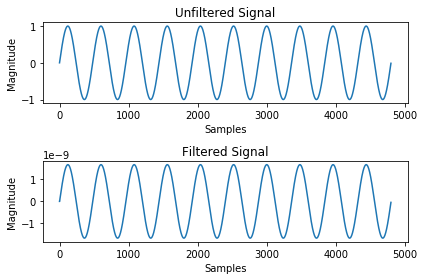

In [8]:
import matplotlib.pyplot as plt #For plotting
from math import sin, pi #For generating input signals
import sys #For reading command line arguments
import scipy.signal as sig
import numpy as np

### Filter - 6KHz->8Khz Bandpass Filter
### @param [in] input - input unfiltered signal
### @param [out] output - output filtered signal
def filter(x , coefb, coefa):
    y = [0]*48000
    for n in range(3, len(x)):
        y[n] = (coefb[0]*x[n] + coefb[1]*x[n-1]+  coefb[2]*x[n-2] -(coefa[1]*y[n-1] + coefa[2]*y[n-2]))/(2**Exp)
    return y

###Read in desired frequency from command line
#frequency = int(sys.argv[1])
frequency = 100

## Create the filter
Fs = 48000           #Sample Frequ
sample = 48000       #Number of Samples
f = 100             #Sig gen Frequ
n = 2               #Order of Filter
rs = 30             #only for Cheby
fc = 20            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Exp = 12
[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")
print("Filter Coefs: coefa and coefb:")
print(coefa,coefb)


### Create empty arrays
input = [0]*48000
output = [0]*48000

### Fill array with xxxHz signal
for i in range(48000):
    input[i] = sin(2 * pi * frequency * i / 48000) #+ sin(2 * pi * 70 * i / 48000)

### Run the signal through the filter
output = filter(input,coefb,coefa)

### Grab samples from input and output #1/100th of a second
output_section = output[0:4800]
input_section = input[0:4800]

### Plot the signals for comparison
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input_section)
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output_section)
plt.tight_layout()
plt.show()


Here it is easy to see that a IIR Filter does a pretty awesome Job. A 100Hz signal which is given to a second order IIR filter with a cutoff frequency of 20 Hz is cuted down to a Amplitude with the size of 1*10^-7.


In the next example I try to change this code to see how bad the result gets when I sample with 20 bits. I try manually to avoid an overflow which is easy because I work with 32 bit Integers. So basically I multiply my code with a factor and compare the floatingpoint results from above with the fixpoint results.
In the following code I use a Faktor of 20.
Why 20?
Because the smallest number is 1.71030589e-06.
To scale this number at least to 1 I need a Exp of 20
If I would fall below this some factors of the coefb will be 0 wich will result in worse results.


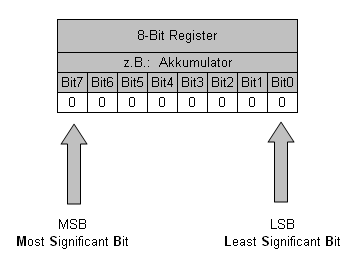

In [39]:
from IPython.display import Image
Image("img/SB_LSB_8bit.gif")

old coefa and coefb:
[ 1.         -1.9962976   0.99630444] [1.71030589e-06 3.42061178e-06 1.71030589e-06]
new coefa and coefb:
[ 1048576. -2093269.  1044700.] [1. 3. 1.]
<class 'numpy.int32'>
-0b111111111000011010101


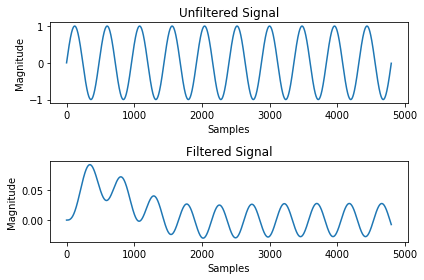

In [18]:
import matplotlib.pyplot as plt #For plotting
from math import sin, pi #For generating input signals
import sys #For reading command line arguments
import scipy.signal as sig
import numpy as np

### Filter - 6KHz->8Khz Bandpass Filter
### @param [in] input - input unfiltered signal
### @param [out] output - output filtered signal
def filter(x , coefb, coefa):
    y = [0]*48000
    for n in range(3, len(x)):
        y[n] = (coefb[0]*x[n] + coefb[1]*x[n-1]+  coefb[2]*x[n-2] -(coefa[1]*y[n-1] + coefa[2]*y[n-2]))/(2**Exp)
    return y

###Read in desired frequency from command line
#frequency = int(sys.argv[1])
frequency = 100

## Create the filter
Fs = 48000           #Sample Frequ
sample = 48000       #Number of Samples
f = 100             #Sig gen Frequ
n = 2               #Order of Filter
rs = 30             #only for Cheby
fc = 20            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Exp = 20
[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")

###Used to do test for the needed Exponent
print("old coefa and coefb:")
print(coefa,coefb)
i=0
for c in coefa:
    coefa[i] = np.int(coefa[i]*2**Exp)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    i=i+1
i=0
for c in coefb:
    coefb[i] = int(coefb[i]*2**Exp)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    i=i+1
print("new coefa and coefb:")
print(coefa,coefb)
coefa = coefa.astype('int32')
print(type(coefa[0]))
print(bin(coefa[1]))
###########################################


### Create empty arrays
input = [0]*48000
output = [0]*48000

### Fill array with xxxHz signal
for i in range(48000):
    input[i] = sin(2 * pi * frequency * i / 48000) #+ sin(2 * pi * 70 * i / 48000)

### Run the signal through the filter
output = filter(input,coefb,coefa)

### Grab samples from input and output #1/100th of a second
output_section = output[0:4800]
input_section = input[0:4800]

### Plot the signals for comparison
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input_section)
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output_section)
plt.tight_layout()
plt.show()


The next step is not to make the whole Internal working part of my "Filter" ready for the Fixpoint calc.
Therefore I scale the input Signal with the same factor then the coeficients. 
I implement the type conversions to int 32 and at the End a recalculation to a float for the comparison.


[ 1.         -1.9962976   0.99630444] [1.71030589e-06 3.42061178e-06 1.71030589e-06]
[ 1048576 -2093269  1044700]
[1 3 1]


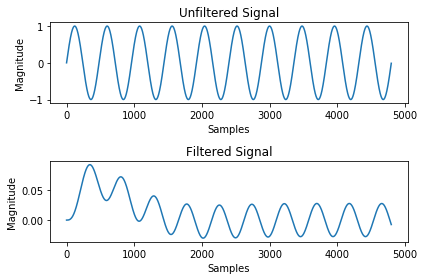

In [20]:
import matplotlib.pyplot as plt #For plotting
from math import sin, pi #For generating input signals
import sys #For reading command line arguments
import scipy.signal as sig
import numpy as np

### Filter - 6KHz->8Khz Bandpass Filter
### @param [in] input - input unfiltered signal
### @param [out] output - output filtered signal
def filter(x , coefb, coefa):
    y = [0]*48000
    for n in range(0, len(x)):
        y[n] = coefa[0]*y[n]/(2**Exp)
        for m in range(len(coefb)):
            y[n] = y[n] +  (coefb[m]*x[n-m] -(coefa[m]*y[n-m]))/(2**Exp)
        #y[n] = (coefb[0]*x[n] + coefb[1]*x[n-1]+  coefb[2]*x[n-2] -(coefa[1]*y[n-1] + coefa[2]*y[n-2]))/(2**Exp)
    return y

###Read in desired frequency from command line
#frequency = int(sys.argv[1])
frequency = 100

## Create the filter
Fs = 48000           #Sample Frequ
samples = 48000       #Number of Samples
f = 100             #Sig gen Frequ
n = 2               #Order of Filter
rs = 30             #only for Cheby
fc = 20            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Exp = 20
Type = 'int32'      #Type of the internal calc

[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")

###Used to do test for the needed Exponent
print(coefa,coefb)
i=0
for c in coefa:
    coefa[i] = np.int(coefa[i]*2**Exp)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    i=i+1
coefa = coefa.astype(Type)
print(coefa)
i=0
for c in coefb:
    coefb[i] = int(coefb[i]*2**Exp)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    i=i+1
coefb = coefb.astype(Type)
print(coefb)
###########################################


### Create empty arrays
input = [0]*samples
output = [0]*samples

### Fill array with xxxHz signal
for i in range(samples):
    input[i] = int((2**Exp)*sin(2 * pi * frequency * i / samples)) #+ sin(2 * pi * 70 * i / 48000)
      #Scale the input with 2**Exp

### Run the signal through the filter
output = filter(input,coefb,coefa)

### Grab samples from input and output #1/100th of a second
output_section = output[0:4800]
output_section = [i / (2**Exp) for i in output_section]
input_section = input[0:4800]
input_section = [i / (2**Exp) for i in input_section]

### Plot the signals for comparison
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input_section)
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output_section)
plt.tight_layout()
plt.show()


In the next step I try do implenent a automatized coef scaler, which always trys to choose the lowest possible amount of bits necessary to make the system working.